In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
data_path = "drive/My Drive/msFardin/_data/"
!ls "drive/My Drive/msFardin/_data/"

# !cd "drive/My Drive/msFardin/_data/" && gunzip kddcup.data_10_percent.gz

Mounted at /content/drive
kddcup.data_10_percent	kddcup.names


In [ ]:
import pandas as pd
import numpy as np
import os
from datetime import datetime 

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline


import sys
sys.path.append('drive/My Drive/msFardin')

try:
    import catboost
except:
    !pip install catboost
    import catboost
print('catboost.__version__',catboost.__version__)
from catboost import CatBoostClassifier


In [4]:
# ['http', 'smtp', 'finger', 'domain_u', 'auth', 'telnet', 'ftp',
  # 'eco_i', 'ntp_u', 'ecr_i', 'other', 'private', 'pop_3', 'ftp_data',
  # 'rje', 'time', 'mtp', 'link', 'remote_job', 'gopher', 'ssh',
  # 'name', 'whois', 'domain', 'login', 'imap4', 'daytime', 'ctf',
  # 'nntp', 'shell', 'IRC', 'nnsp', 'http_443', 'exec', 'printer',
  # 'efs', 'courier', 'uucp', 'klogin', 'kshell', 'echo', 'discard',
  # 'systat', 'supdup', 'iso_tsap', 'hostnames', 'csnet_ns', 'pop_2',
  # 'sunrpc', 'uucp_path', 'netbios_ns', 'netbios_ssn', 'netbios_dgm',
  # 'sql_net', 'vmnet', 'bgp', 'Z39_50', 'ldap', 'netstat', 'urh_i',
  # 'X11', 'urp_i', 'pm_dump', 'tftp_u', 'tim_i', 'red_i']       


selected_service = ['smtp', 'http']
feature_mode = 2 #2 or  1


with open(data_path+'kddcup.names', 'r') as infile:
    kdd_names = infile.readlines()
    kdd_cols = [x.split(':')[0] for x in kdd_names[1:]]

kdd_cols.append('Class')
data_file = data_path + "kddcup.data_10_percent"
main_df = pd.read_csv(data_file, names = kdd_cols, header=None)
print(len(main_df))
print(len(main_df.columns))
print(main_df.columns)
main_df.head()
# main_df.service.unique()

494021
42
Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'Class'],
      dtype='object')


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Class
0,0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


#Data Stream

In [5]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

print("1:main_df.shape=>",main_df.shape)
df = main_df.loc[main_df['service'].isin(selected_service),:] 
print("2:df.shape=>",df.shape)
df = df.dropna() 
print("3:df.shape=>",df.shape)


if feature_mode==1:
    selected_column = ['duration','flag','src_bytes',
                      'dst_bytes','logged_in','count',
                      'srv_count','srv_diff_host_rate','dst_host_count',
                      'dst_host_srv_count','dst_host_same_src_port_rate','Class']
else:
    selected_column = []
    for col in df.columns[:-1]:
        if len(df[col].unique())>1:
              selected_column.append(col)

    selected_column.append('Class')

df = df[selected_column]

# types = {}
# for var in df.columns[:-1]:
#     if df[var].dtype == 'object':
#         types[var] = 'categorical'

for col in df.columns[:-1]:
    if df[col].dtype == 'object':
        df[col] = (pd.factorize(df[col],sort=True)[0]).astype(np.int)
# print(df.dtypes)


from collections import Counter
print('Labels=>',df.Class.unique())
print('Labels Histogram=>',Counter(df.Class))


df.Class[df.Class!='normal.']='1'
df.Class[df.Class=='normal.']='0'
print('Binary Labels Histogram=>',Counter(df.Class))

df.Class=df.Class.astype(np.int)

train = df.iloc[:int(len(df)*0.7),:]
test = df.iloc[int(len(df)*0.7):,:]

print("Train.samples=>",len(train))
print("Test.shape=>",len(test))


x_train=train.drop(['Class'],axis=1)
y_train=train['Class']

x_test=test.drop(['Class'],axis=1)
y_test=test['Class']

print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
print((y_test==1).sum())
print((y_test==0).sum())
categorical_features_indices = np.where(x_train.dtypes == 'object')[0]


1:main_df.shape=> (494021, 42)
2:df.shape=> (74016, 42)
3:df.shape=> (74016, 42)
Labels=> ['normal.' 'ipsweep.' 'back.' 'phf.' 'neptune.' 'portsweep.' 'satan.']
Labels Histogram=> Counter({'normal.': 71484, 'back.': 2203, 'neptune.': 312, 'portsweep.': 5, 'ipsweep.': 4, 'phf.': 4, 'satan.': 4})
Binary Labels Histogram=> Counter({'0': 71484, '1': 2532})
Train.samples=> 51811
Test.shape=> 22205
(51811, 32) (51811,) (22205, 32) (22205,)
479
21726


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#CATBoost on Data Stream

In [11]:
model = CatBoostClassifier(
    loss_function='Logloss',
    custom_loss=['Logloss', 'AUC'],
    eval_metric='F1',
    iterations=50,
    learning_rate=0.4,
    random_state=20, 
    verbose=0,
    train_dir='it_150_lr_0.4',
    use_best_model=False
)

model.fit(
    x_train, y_train,
    cat_features=categorical_features_indices
)


_batch_size = 4096
res_Class = []

new_x_train = x_train.copy()
new_y_train = y_train.copy()

for idx in range(0,len(x_test),_batch_size):

    i_min = idx
    i_max = idx + _batch_size
    i_max = np.min([i_max,len(x_test)])
    # print(i_min,i_max)
    data_batch_x = x_test.iloc[i_min:i_max,:]
    data_batch_y = y_test.iloc[i_min:i_max]

    res_Class.extend(model.predict(data_batch_x))

    new_x_train,new_y_train = resample(new_x_train,new_y_train, 
                                      replace=False,    # sample without replacement
                                      n_samples=5000,     
                                      random_state=123) # reproducible results

    new_x_train = pd.concat([new_x_train, data_batch_x])
    new_y_train = pd.concat([new_y_train, data_batch_y])
    model.fit(
          new_x_train, new_y_train,
          cat_features=categorical_features_indices
        )


y_pred = np.array(res_Class)

y_true = y_test.values


from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
Accuracy = (tp + tn) / (tp + fp + fn + tn)
ACC = Accuracy.sum()
print('Confusion matrix(test):\n{}'.format(confusion_matrix(y_true, y_pred)))
print("Accuracy", ACC)
Precision = tp/(tp+fp)
print("Precision", Precision)
Recall = tp/(tp+fn)
print("Recall",Recall)

Confusion matrix(test):
[[21726     0]
 [   16   463]]
Accuracy 0.9992794415672146
Precision 1.0
Recall 0.9665970772442589


#CATBoost




In [8]:
model = CatBoostClassifier(
    loss_function='Logloss',
    custom_loss=['Logloss', 'AUC'],
    eval_metric='F1',
    iterations=50,
    learning_rate=0.4,
    random_state=20, 
    verbose=1,
    train_dir='it_150_lr_0.4',
    use_best_model=False
)
print('Model params:')
print(model.get_params())
print()

print('Staring training catboost model...')
model.fit(
    x_train, y_train,
    eval_set=(x_test,y_test),
    cat_features=categorical_features_indices
)
print('Best score is:')
print(model.best_score_)
print('Best iteration is: '+ str(model.best_iteration_))
print('Tree counts of Catboost with best parameters: ' + str(model.tree_count_))

# model.save_model('catboost_model.dump')
# model = CatBoostClassifier()
# model.load_model('catboost_model.dump')
# model.predict(x_test)

Model params:
{'random_state': 20, 'eval_metric': 'F1', 'custom_loss': ['Logloss', 'AUC'], 'train_dir': 'it_150_lr_0.4', 'verbose': 10, 'use_best_model': False, 'loss_function': 'Logloss', 'learning_rate': 0.4, 'iterations': 50}

Staring training catboost model...
0:	learn: 0.9859224	test: 0.8937644	best: 0.8937644 (0)	total: 23.1ms	remaining: 1.13s
10:	learn: 0.9997564	test: 0.8795322	best: 0.8937644 (0)	total: 253ms	remaining: 896ms
20:	learn: 1.0000000	test: 0.8873403	best: 0.8937644 (0)	total: 474ms	remaining: 654ms
30:	learn: 1.0000000	test: 0.9175141	best: 0.9199549 (23)	total: 670ms	remaining: 411ms
40:	learn: 1.0000000	test: 0.9175141	best: 0.9199549 (23)	total: 849ms	remaining: 186ms
49:	learn: 1.0000000	test: 0.9138322	best: 0.9199549 (23)	total: 1s	remaining: 0us

bestTest = 0.9199549042
bestIteration = 23

Best score is:
{'learn': {'Logloss': 5.153079218898302e-05, 'F1': 1.0}, 'validation': {'Logloss': 0.013056749571561119, 'F1': 0.9199549041713642, 'AUC': 0.999559132463398

In [9]:

y_pred = model.predict(x_test)
y_true = y_test


from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
Accuracy = (tp + tn) / (tp + fp + fn + tn)
ACC = Accuracy.sum()
print('Confusion matrix(test):\n{}'.format(confusion_matrix(y_true, y_pred)))
print("Accuracy", ACC)
Precision = tp/(tp+fp)
print("Precision", Precision)
Recall = tp/(tp+fn)
print("Recall",Recall)

Confusion matrix(test):
[[21726     0]
 [   76   403]]
Accuracy 0.9965773474442693
Precision 1.0
Recall 0.8413361169102297


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 6 not upgraded.
Need to get 154 kB of archives.
After this operation, 613 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 poppler-utils amd64 0.62.0-2ubuntu2.10 [154 kB]
Fetched 154 kB in 0s (2,266 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 144617 files and directories currently installed.)
Preparing to unpack .../poppler-utils_0.62.0-2ubuntu2.10_amd64.deb ...
Unpacking poppler-utils (0.62.0-2ubuntu2.10) ...
Setting up poppler-utils (0.62.0-2ubuntu2.10) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


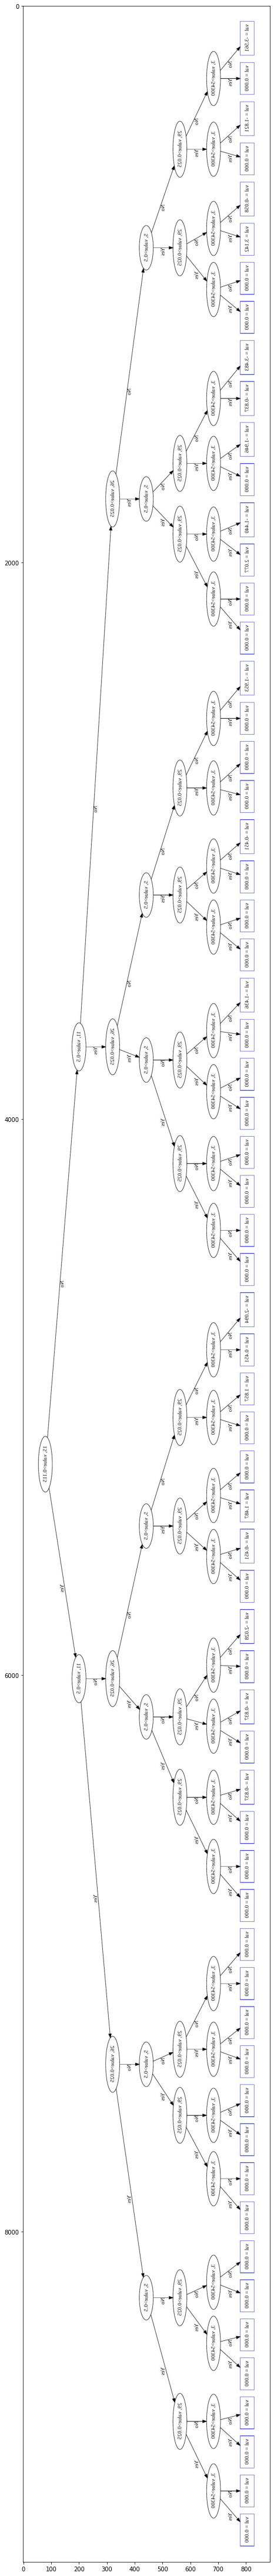

In [ ]:
x = model.plot_tree(0)
x.render()
# model.get_feature_importance()
# !ls -s

!apt-get install poppler-utils 
!pip install pdf2image
from pdf2image import convert_from_path
pages = convert_from_path('Digraph.gv.pdf',100)
for p in pages:
  p.save('out.jpg', 'JPEG')



import cv2
img = cv2.imread('out.jpg')
img = img.transpose([1,0,2])
img.shape
# img = cv2.resize(img,(500,3000))
fig, ax = plt.subplots(figsize=(50, 80))
plt.imshow(img)
plt.show()

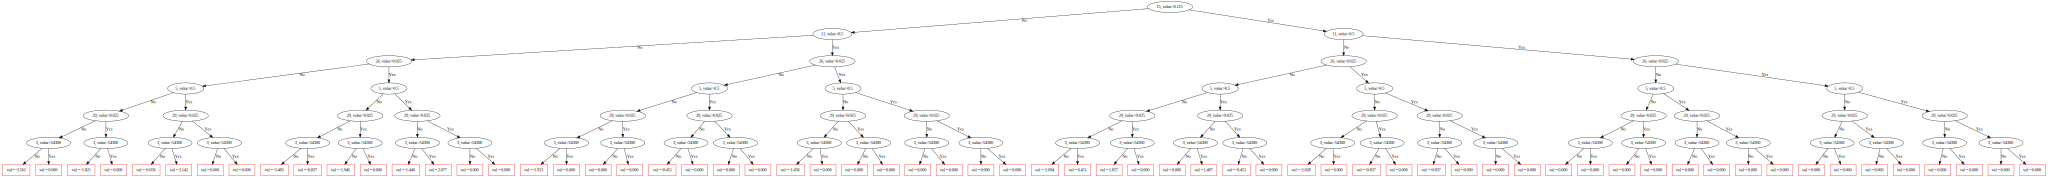

In [ ]:
model.plot_tree(0)